<a href="https://colab.research.google.com/github/Bae-hong-seob/LG-Aimers2/blob/main/preliminaries/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dataset Info.

## train.csv [파일] 598(rows) * 2881(columns)
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
- Y_Quality : 제품 품질 수치
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


## test.csv [파일]
- PRODUCT_ID : 제품의 고유 ID
- TIMESTAMP : 제품이 공정에 들어간 시각
- LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
- PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
- X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수


## sample_submission.csv [파일] - 제출 양식
- PRODUCT_ID : 제품의 고유 ID
- Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

실제 공정 과정에서의 데이터로, 보안상의 이유로 일부 변수가 비식별화 처리 되었습니다. (X변수)
'LINE', 'PRODUCT_CODE'는 Train / Test 모두 동일한 종류가 존재합니다.

## 평가 산식 : Macro F1 Score
- Public score : 전체 테스트 데이터의 30%
- Private score : 전체 테스트 데이터의 100%

In [ ]:
import numpy as np
import pandas as pd
import os
import math
import random 

from scipy import stats #Analysis 
from scipy.stats import norm 

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/LGaimers/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/LGaimers/test.csv')

In [ ]:
train_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


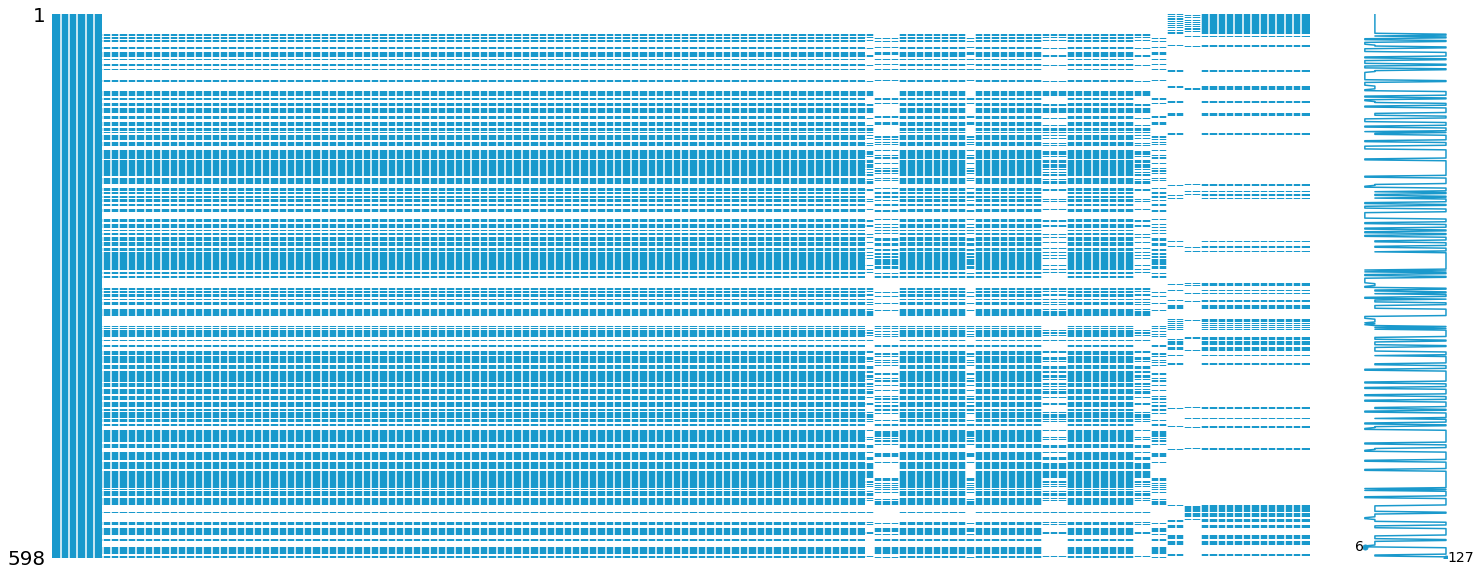

In [ ]:
msno.matrix(train_df.iloc[:,:150], color=(0.1, 0.6, 0.8))

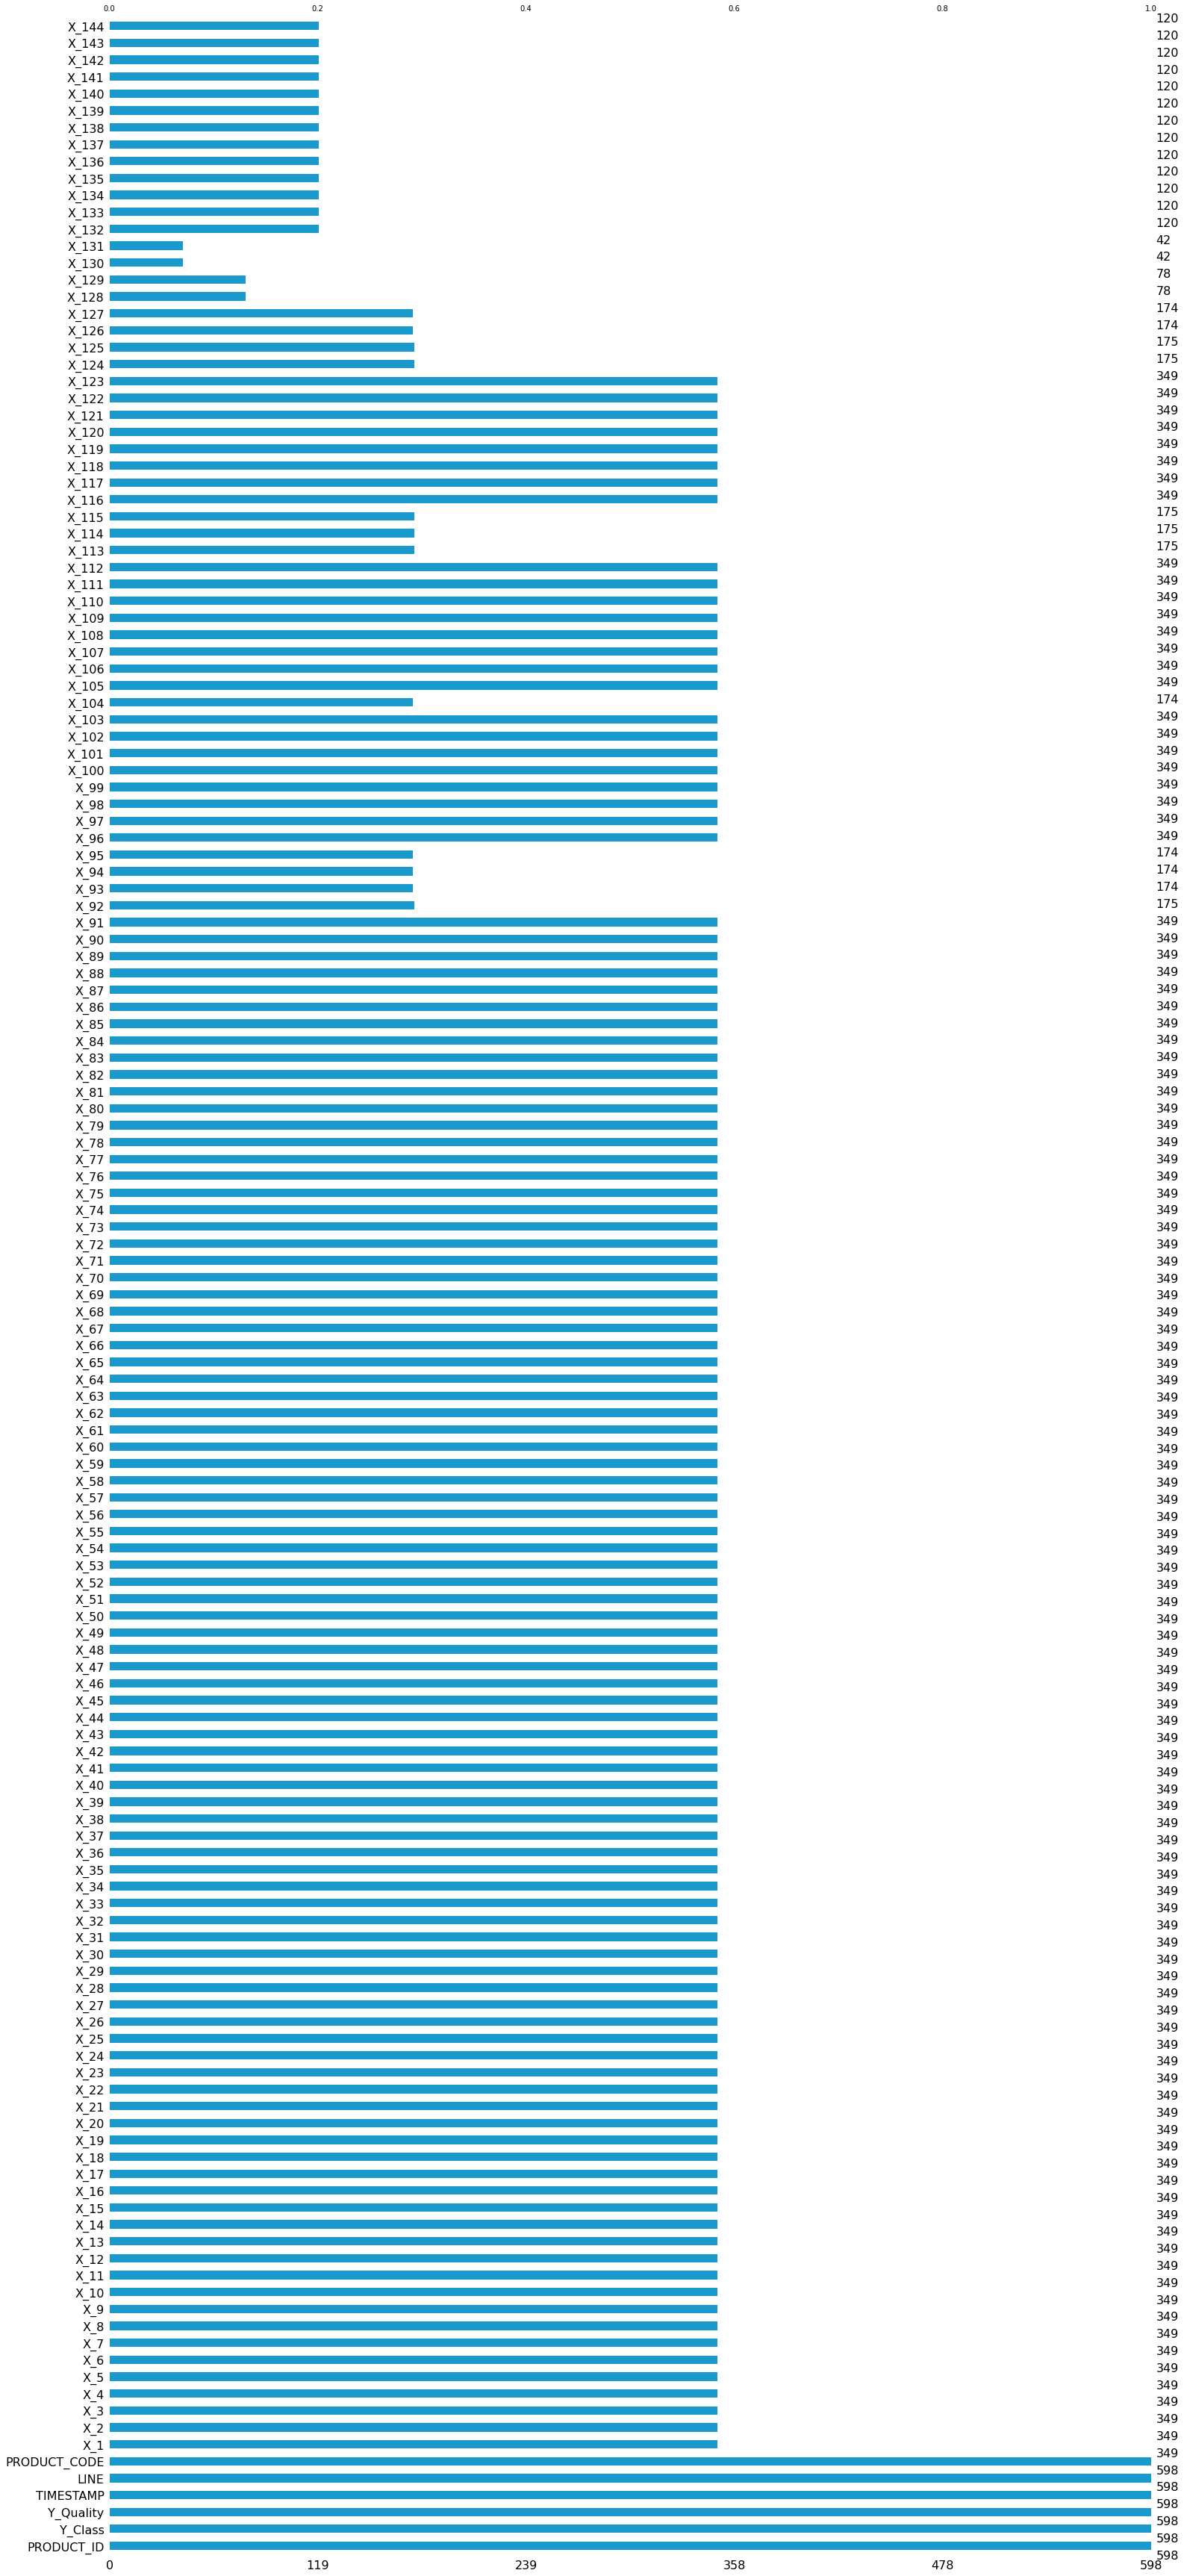

In [ ]:
msno.bar(train_df.iloc[:,:150], color=(0.1, 0.6, 0.8))

## Y_Class 별 data split

In [ ]:
below_standard_df = train_df[train_df['Y_Class']==0]
below_standard_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,TRAIN_028,0,0.521249,2022-06-19 20:26,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,TRAIN_034,0,0.521524,2022-06-21 17:36,T050304,A_31,NaN,NaN,NaN,NaN,...,55.03,52.24,55.33,57.49,67.31,1.0,NaN,NaN,NaN,NaN
66,TRAIN_066,0,0.524408,2022-06-25 21:38,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


In [ ]:
normal_standard_df = train_df[train_df['Y_Class']==1]
normal_standard_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,2.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
over_standard_df = train_df[train_df['Y_Class']==2]
over_standard_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
5,TRAIN_005,2,0.537833,2022-06-13 5:55,T050307,A_31,NaN,NaN,NaN,NaN,...,38.16,51.25,56.01,37.41,71.37,NaN,NaN,NaN,NaN,NaN
7,TRAIN_007,2,0.540003,2022-06-13 6:11,T050307,A_31,NaN,NaN,NaN,NaN,...,39.00,35.95,59.51,30.49,72.77,NaN,NaN,NaN,NaN,NaN
9,TRAIN_009,2,0.538049,2022-06-13 6:28,T050307,A_31,NaN,NaN,NaN,NaN,...,34.40,35.88,50.36,38.45,71.42,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563,TRAIN_563,2,0.537465,2022-09-03 1:22,T050304,A_31,NaN,NaN,NaN,NaN,...,49.92,54.66,50.56,48.63,62.17,1.0,NaN,NaN,NaN,NaN
564,TRAIN_564,2,0.540106,2022-09-03 1:30,T050304,A_31,NaN,NaN,NaN,NaN,...,57.94,55.84,53.24,56.72,64.17,1.0,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## PRODUCT CODE 별 data split

In [ ]:
A_31_df = train_df[train_df['PRODUCT_CODE']=='A_31']
A_31_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


In [ ]:
T_31_df = train_df[train_df['PRODUCT_CODE']=='T_31']
T_31_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,TRAIN_025,1,0.529362,2022-06-19 9:11,T100304,T_31,2.0,97.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,TRAIN_026,1,0.531992,2022-06-19 9:20,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,TRAIN_029,1,0.532405,2022-06-19 23:31,T100304,T_31,2.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,TRAIN_589,1,0.529510,2022-09-06 18:00,T100306,T_31,1.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,TRAIN_590,1,0.529948,2022-09-07 1:01,T100306,T_31,1.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,2.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
O_31_df = train_df[train_df['PRODUCT_CODE']=='O_31']
O_31_df

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
569,TRAIN_569,1,0.530533,2022-09-03 18:32,T100304,O_31,4.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,TRAIN_597,1,0.533702,2022-09-08 14:46,T100306,O_31,21.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


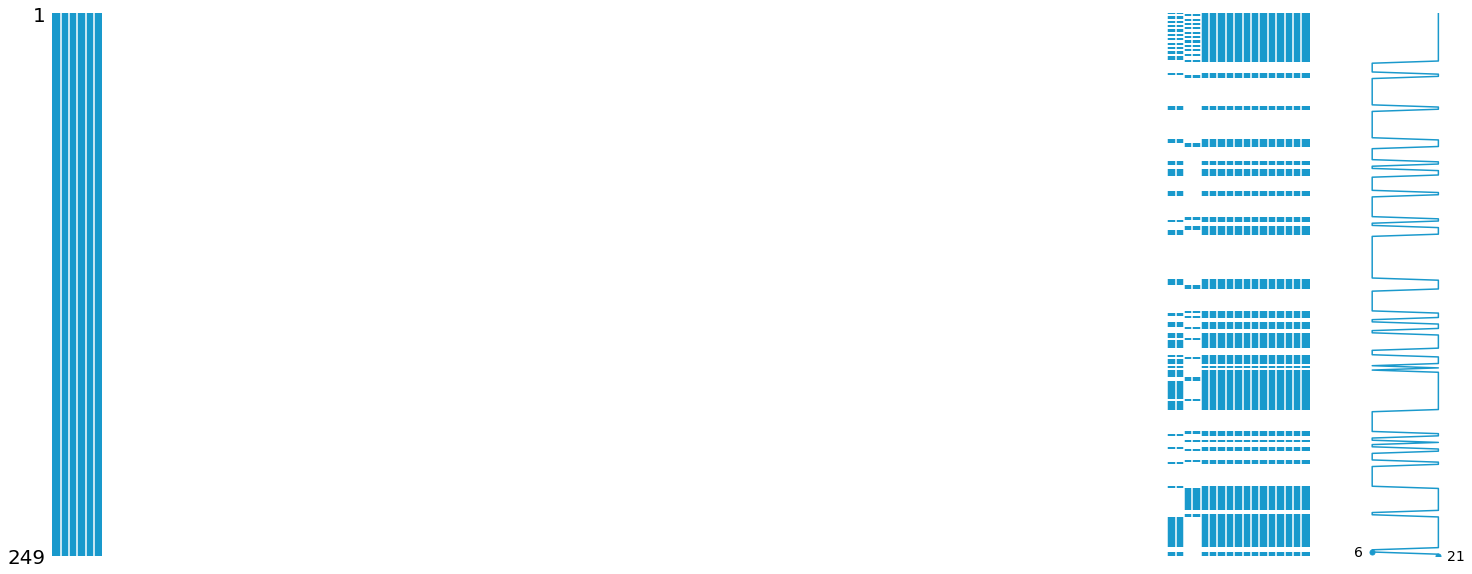

In [ ]:
msno.matrix(A_31_df.iloc[:,:150], color=(0.1, 0.6, 0.8))

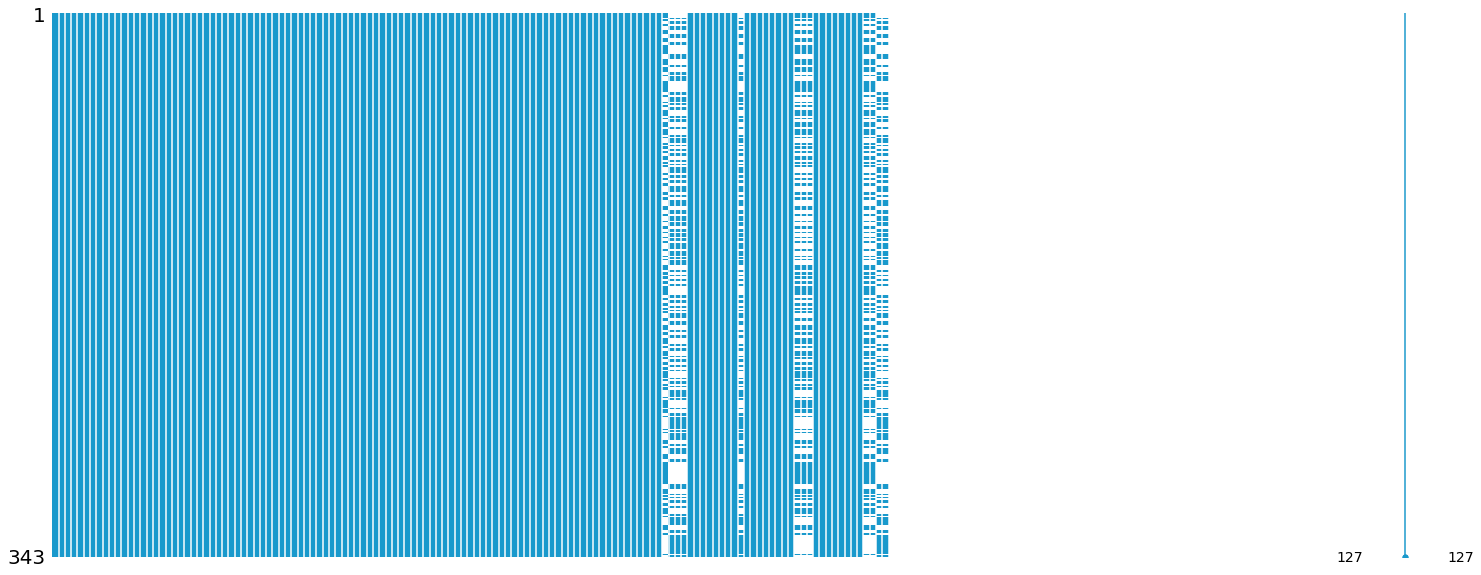

In [ ]:
msno.matrix(T_31_df.iloc[:,:200], color=(0.1, 0.6, 0.8))

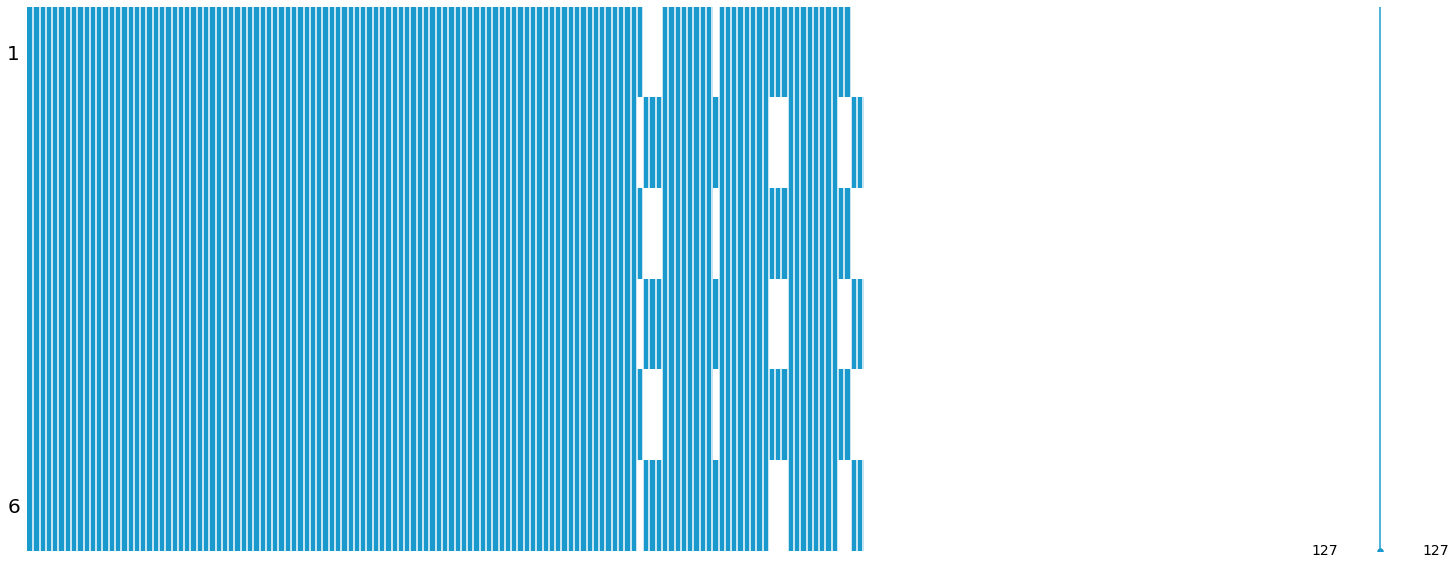

In [ ]:
msno.matrix(O_31_df.iloc[:,:200], color=(0.1, 0.6, 0.8))

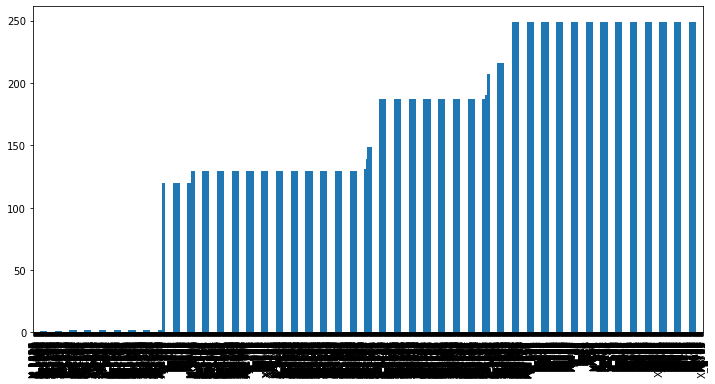

In [ ]:
missing = A_31_df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(figsize = (12,6))

## LINE 별 Y_Class
  - LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)

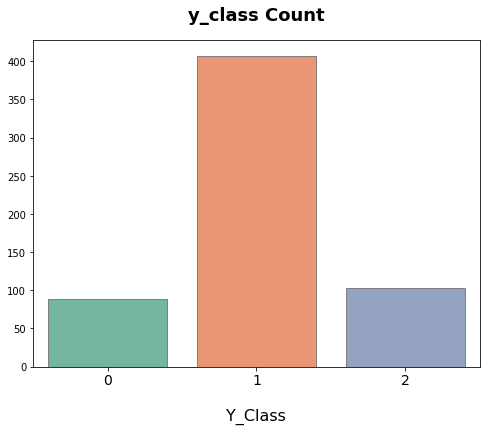

In [ ]:
# total Y_Class 분포
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=train_df["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

In [ ]:
T050304 = train_df[train_df['LINE'] == 'T050304']
T050307 = train_df[train_df['LINE'] == 'T050307']
T100304 = train_df[train_df['LINE'] == 'T100304']
T100306 = train_df[train_df['LINE'] == 'T100306']
T010306 = train_df[train_df['LINE'] == 'T010306']
T010305 = train_df[train_df['LINE'] == 'T010305']

### T050304

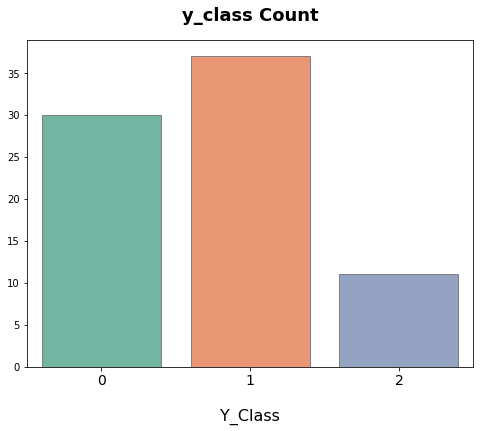

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T050304["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

### T050307

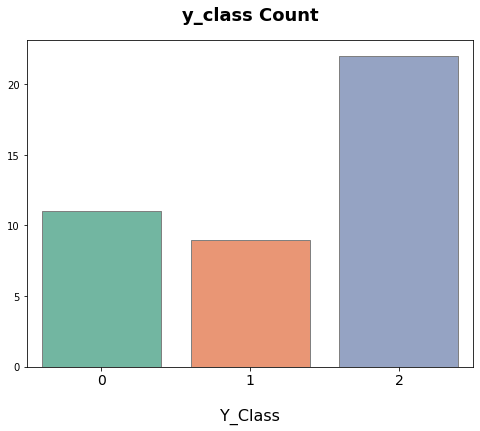

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T050307["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

### T100304

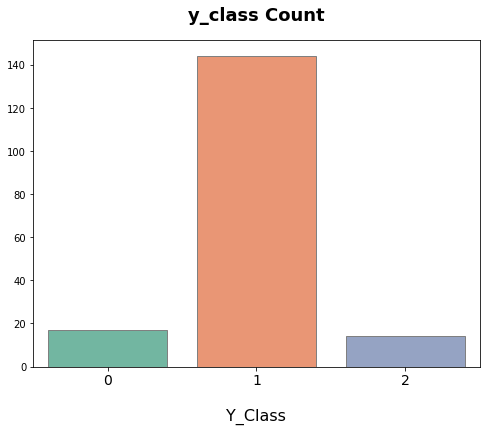

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T100304["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

### T100306

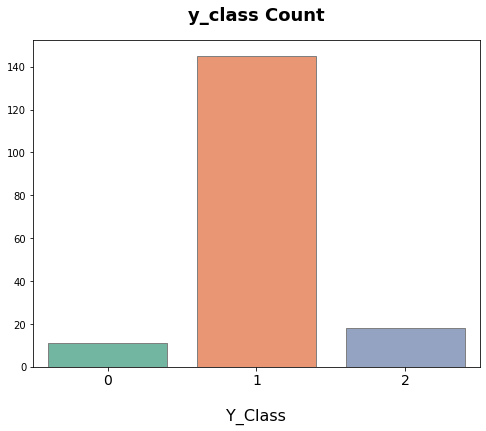

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T100306["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

### T010306

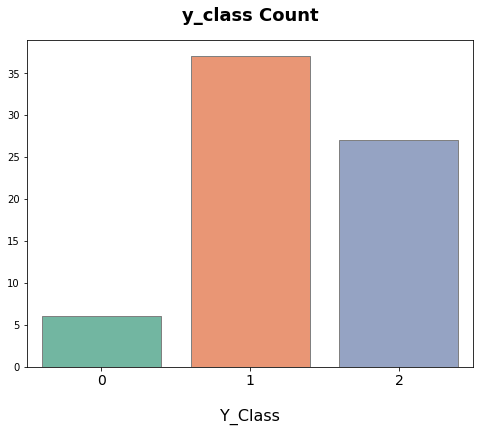

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T010306["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

### T010305

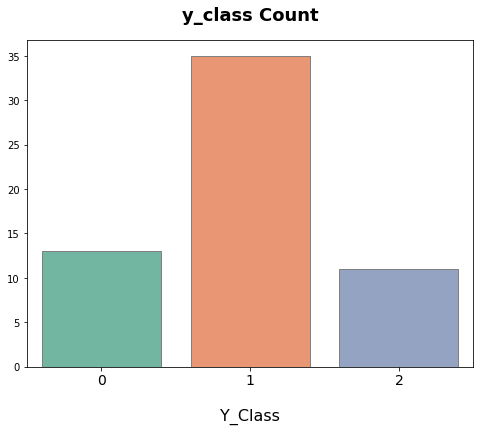

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T010305["Y_Class"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("y_class Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## line 별 product code

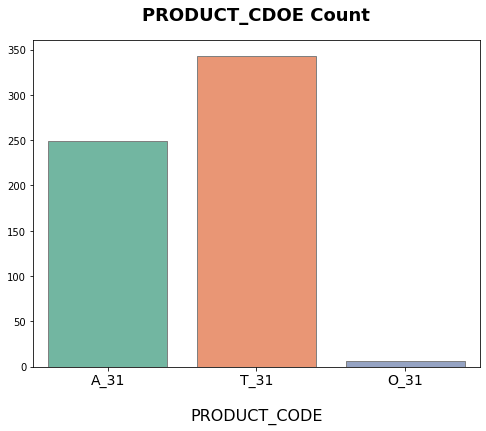

In [ ]:
# total Y_Class 분포
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=train_df["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("PRODUCT_CDOE Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## T050304

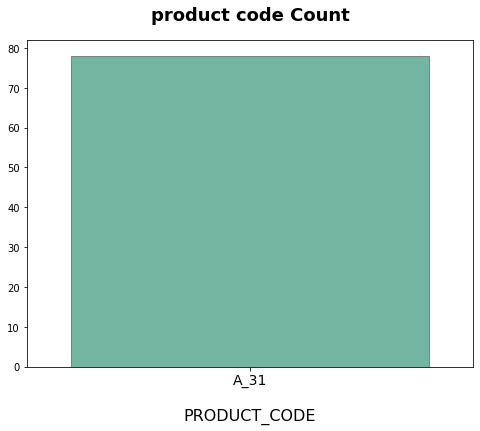

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T050304["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("product code Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## T050307

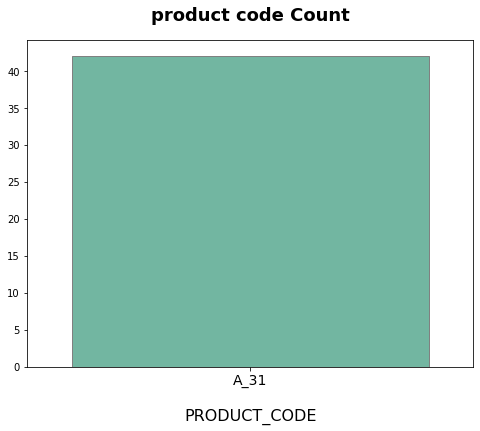

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T050307["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("product code Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## T100304

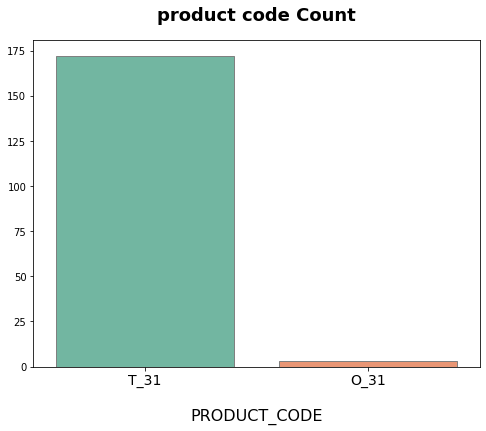

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T100304["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("product code Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## T100306

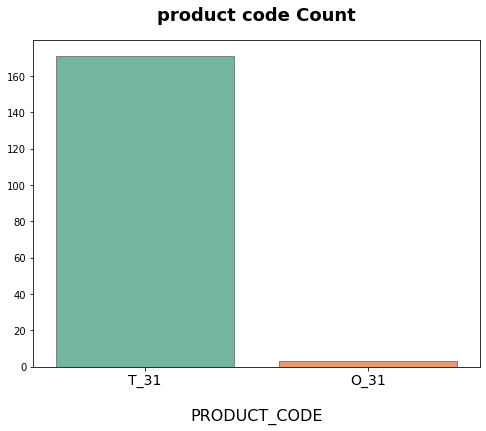

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T100306["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("product code Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## T010306

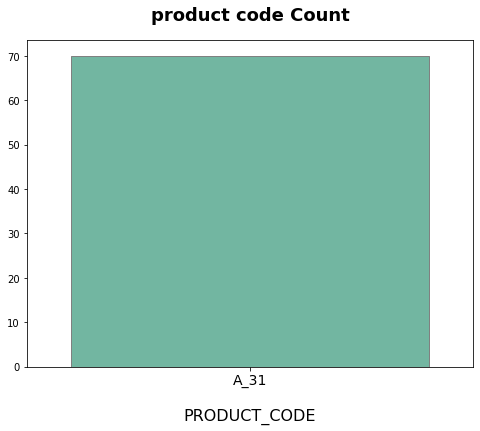

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T010306["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("product code Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## T010305


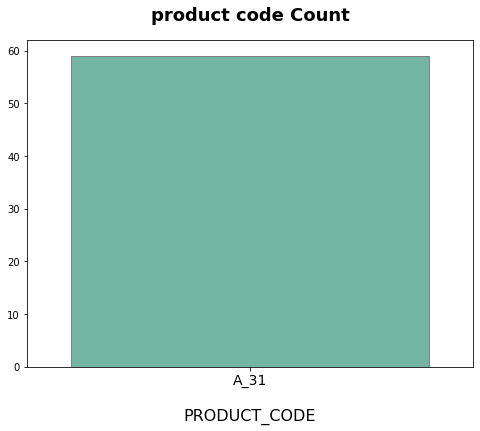

In [ ]:
sns.set_palette("Set2")

fig, ax = plt.subplots(figsize=(8, 6))
graph = sns.countplot(x=T010305["PRODUCT_CODE"], edgecolor="grey")

plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
plt.ylabel("", fontsize=16, labelpad=20)

plt.xticks(fontsize=14)

plt.title("product code Count", fontsize=18, fontweight="bold", pad=20)

plt.show()

## 결측치 제거

In [ ]:
col_list = train_df.columns
nan_list = []
nan_cnt = []
nan_col = []
full_list = []
for col in col_list:
    if train_df[col].isnull().sum() == 0 :
        full_list.append(col)
        continue
    nan_list.append([col, train_df[col].isnull().sum()])
    nan_cnt.append(train_df[col].isnull().sum())
    nan_col.append(col)

In [ ]:
'''모든값이 결측값이면 제거'''

del_col = []
for col in nan_list :
    if col[1] == 598 :
        del_col.append(col[0])
train_df = train_df.drop(columns=del_col)
test_df = test_df.drop(columns=del_col)
train_df.head(3)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN


##### product code별 data split

In [ ]:
trainA_31 = train_df[train_df['PRODUCT_CODE']=='A_31']
train_T_O = train_df[train_df['PRODUCT_CODE']!='A_31']

testA_31 = test_df[test_df['PRODUCT_CODE']=='A_31']
test_T_O = test_df[test_df['PRODUCT_CODE']!='A_31']

In [ ]:
#PRODUCT_CODE = A_31 결측치 제거
col_list = train_df.columns
nan_listA_31 = []
nan_cntA_31 = []
nan_colA_31 = []
full_listA_31 = []
for col in col_list:
    if trainA_31[col].isnull().sum() == 0 :
        full_listA_31.append(col)
        continue
    nan_listA_31.append([col, trainA_31[col].isnull().sum()])
    nan_cntA_31.append(trainA_31[col].isnull().sum())
    nan_colA_31.append(col)

'''모든값이 결측값이면 제거'''
del_col = []
for col in nan_listA_31 :
    if col[1] == len(trainA_31) :
        del_col.append(col[0])
trainA_31 = trainA_31.drop(columns=del_col)
testA_31 = testA_31.drop(columns=del_col)
trainA_31.head(3)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,7813.0,7813.0,NaN,NaN,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,19854.0,19854.0,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,7815.0,7815.0,NaN,NaN,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,NaN


In [ ]:
#PRODUCT_CODE = T_31 결측치 제거
col_list = train_df.columns
nan_listT_O = []
nan_cntT_O = []
nan_colT_O = []
full_listT_O = []
for col in col_list:
    if train_T_O[col].isnull().sum() == 0 :
        full_listT_O.append(col)
        continue
    nan_listT_O.append([col, train_T_O[col].isnull().sum()])
    nan_cntT_O.append(train_T_O[col].isnull().sum())
    nan_colT_O.append(col)

'''모든값이 결측값이면 제거'''
del_col = []
for col in nan_listT_O :
    if col[1] == len(train_T_O) :
        del_col.append(col[0])
train_T_O = train_T_O.drop(columns=del_col)
test_T_O = test_T_O.drop(columns=del_col)
train_T_O.head(3)

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_924,X_925,X_926,X_927,X_928,X_929,X_930,X_931,X_932,X_933
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,172.5,162.8,157.235484,150.9,326.0,309.290909,290.0,13.7,13.443333,13.2
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,TRAIN_025,1,0.529362,2022-06-19 9:11,T100304,T_31,2.0,97.0,0.0,45.0,...,177.8,157.1,154.074194,150.9,327.0,310.854546,298.0,13.7,13.454839,13.2


In [ ]:
#train_x 변수 생성
trainA_31_x = trainA_31.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE','Y_Class','Y_Quality'])
testA_31_x = testA_31.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE'])
train_T_O_x = train_T_O.drop(columns=['PRODUCT_ID','TIMESTAMP','Y_Class','Y_Quality','PRODUCT_CODE'])
test_T_O_x = test_T_O.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE'])

In [ ]:
trainA_31_x=trainA_31_x.fillna(-1)
testA_31_x=testA_31_x.fillna(-1)
train_T_O_x=train_T_O_x.fillna(-1)
test_T_O_x=test_T_O_x.fillna(-1)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# qualitative to quantitative
qual_col = ['LINE']
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(trainA_31_x[i])
    trainA_31_x[i] = le.transform(trainA_31_x[i])
    
    for label in np.unique(testA_31_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    testA_31_x[i] = le.transform(testA_31_x[i]) 
print('Done.')

# qualitative to quantitative
qual_col = ['LINE']
for i in qual_col:
    le = LabelEncoder()
    le = le.fit(train_T_O_x[i])
    train_T_O_x[i] = le.transform(train_T_O_x[i])
    
    for label in np.unique(test_T_O_x[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test_T_O_x[i] = le.transform(test_T_O_x[i]) 
print('Done.')

Done.
Done.


## 다중공선성 확인

In [ ]:
x1tox2875 = ['X_'+str(i) for i in range(1,2876)]
x1tox2875

['X_1',
 'X_2',
 'X_3',
 'X_4',
 'X_5',
 'X_6',
 'X_7',
 'X_8',
 'X_9',
 'X_10',
 'X_11',
 'X_12',
 'X_13',
 'X_14',
 'X_15',
 'X_16',
 'X_17',
 'X_18',
 'X_19',
 'X_20',
 'X_21',
 'X_22',
 'X_23',
 'X_24',
 'X_25',
 'X_26',
 'X_27',
 'X_28',
 'X_29',
 'X_30',
 'X_31',
 'X_32',
 'X_33',
 'X_34',
 'X_35',
 'X_36',
 'X_37',
 'X_38',
 'X_39',
 'X_40',
 'X_41',
 'X_42',
 'X_43',
 'X_44',
 'X_45',
 'X_46',
 'X_47',
 'X_48',
 'X_49',
 'X_50',
 'X_51',
 'X_52',
 'X_53',
 'X_54',
 'X_55',
 'X_56',
 'X_57',
 'X_58',
 'X_59',
 'X_60',
 'X_61',
 'X_62',
 'X_63',
 'X_64',
 'X_65',
 'X_66',
 'X_67',
 'X_68',
 'X_69',
 'X_70',
 'X_71',
 'X_72',
 'X_73',
 'X_74',
 'X_75',
 'X_76',
 'X_77',
 'X_78',
 'X_79',
 'X_80',
 'X_81',
 'X_82',
 'X_83',
 'X_84',
 'X_85',
 'X_86',
 'X_87',
 'X_88',
 'X_89',
 'X_90',
 'X_91',
 'X_92',
 'X_93',
 'X_94',
 'X_95',
 'X_96',
 'X_97',
 'X_98',
 'X_99',
 'X_100',
 'X_101',
 'X_102',
 'X_103',
 'X_104',
 'X_105',
 'X_106',
 'X_107',
 'X_108',
 'X_109',
 'X_110',
 'X_111'

In [ ]:
trainA_31_x

,LINE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,2,7813.0,7813.0,-1.0,-1.0,0.19,0.20,0.19,0.2,228.0,...,189.0,383.0,368.296296,353.0,39.34,40.89,32.56,34.09,77.77,-1.0
1,3,-1.0,-1.0,19854.0,19854.0,0.20,0.21,0.20,0.2,413.0,...,185.6,383.0,367.735849,353.0,38.89,42.82,43.92,35.34,72.55,-1.0
2,2,7815.0,7815.0,-1.0,-1.0,0.19,0.20,0.19,0.2,228.0,...,165.5,383.0,367.320755,353.0,39.19,36.65,42.47,36.53,78.35,-1.0
3,3,-1.0,-1.0,19856.0,19856.0,0.20,0.21,0.20,0.2,414.0,...,165.8,384.0,369.188679,353.0,37.74,39.17,52.17,30.58,71.78,-1.0
4,2,7817.0,7817.0,-1.0,-1.0,0.19,0.20,0.18,0.2,228.0,...,182.6,383.0,367.351852,352.0,38.70,41.89,46.93,33.09,76.97,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,2,11920.0,11920.0,-1.0,-1.0,0.19,0.20,0.19,0.2,230.0,...,181.6,394.0,371.943396,353.0,51.71,59.64,54.61,57.05,63.18,1.0
584,0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,184.9,466.0,448.634615,432.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0
585,1,-1.0,-1.0,-1.0,-1.0,-1.00,-1.00,-1.00,-1.0,-1.0,...,176.7,472.0,450.339623,432.0,-1.00,-1.00,-1.00,-1.00,-1.00,-1.0
594,2,14810.0,14810.0,-1.0,-1.0,0.19,0.20,0.19,0.2,304.0,...,168.7,384.0,369.811321,353.0,49.47,53.07,50.89,55.10,66.49,1.0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(trainA_31_x.values, i) for i in range(trainA_31_x.shape[1])]
vif["features"] = trainA_31_x.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,0.0,X_1701
1,0.0,X_1803
2,0.0,X_1328
3,0.0,X_1157
4,0.0,X_1103
...,...,...
2112,NaN,X_1531
2113,NaN,X_2052
2114,NaN,X_2053
2115,NaN,X_2054


In [ ]:
problem = vif[vif["VIF Factor"] > 9]
problem

,VIF Factor,features
11,4.216254e+04,X_1381
12,4.697680e+04,X_1540
13,5.628085e+04,X_1371
14,5.787233e+04,X_1389
15,6.001107e+04,X_1342
...,...,...
2096,inf,X_323
2097,inf,X_324
2098,inf,X_1057
2099,inf,X_1528


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
trainA_31_x[ : ] = scaler.fit_transform(trainA_31_x[ : ])


In [ ]:
trainA_31_x

,LINE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,0.666667,0.293793,0.293793,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.261714,...,0.918723,0.10,0.113966,0.119565,0.658720,0.601349,0.546491,0.575907,0.975480,0.0
1,1.000000,0.000000,0.000000,0.759099,0.759099,1.000000,1.000000,1.000000,1.0,0.473143,...,0.869376,0.10,0.107939,0.119565,0.651372,0.629055,0.731477,0.596422,0.910836,0.0
2,0.666667,0.293868,0.293868,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.261714,...,0.577649,0.10,0.103476,0.119565,0.656270,0.540482,0.707865,0.615953,0.982663,0.0
3,1.000000,0.000000,0.000000,0.759176,0.759176,1.000000,1.000000,1.000000,1.0,0.474286,...,0.582003,0.11,0.123562,0.119565,0.632593,0.576658,0.865820,0.518300,0.901300,0.0
4,0.666667,0.293943,0.293943,0.000000,0.000000,0.991667,0.991736,0.983333,1.0,0.261714,...,0.825835,0.10,0.103810,0.108696,0.648269,0.615705,0.780492,0.559495,0.965573,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.666667,0.448208,0.448208,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.264000,...,0.811321,0.21,0.153185,0.119565,0.860712,0.870514,0.905553,0.952733,0.794799,1.0
584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.859216,0.93,0.977873,0.978261,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
585,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.740203,0.99,0.996207,0.978261,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
594,0.666667,0.556867,0.556867,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.348571,...,0.624093,0.11,0.130258,0.119565,0.824135,0.776199,0.844976,0.920729,0.835789,1.0


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(trainA_31_x.values, i) for i in range(trainA_31_x.shape[1])]
vif["features"] = trainA_31_x.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF Factor,features
0,inf,LINE
1,inf,X_2108
2,inf,X_2107
3,inf,X_2106
4,inf,X_2105
...,...,...
2112,NaN,X_1823
2113,NaN,X_2052
2114,NaN,X_2053
2115,NaN,X_2054


In [ ]:
problem = vif[vif["VIF Factor"] > 9]
problem

,VIF Factor,features
0,inf,LINE
1,inf,X_2108
2,inf,X_2107
3,inf,X_2106
4,inf,X_2105
...,...,...
2085,inf,X_1384
2086,inf,X_1383
2087,inf,X_1382
2088,inf,X_1380


In [ ]:
vif.to_csv('/content/drive/MyDrive/LGaimers/input/vif_trainA_31_x.csv', index=False)

In [ ]:
trainA_31_x

,LINE,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,...,X_2862,X_2863,X_2864,X_2865,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871
0,0.666667,0.293793,0.293793,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.261714,...,0.918723,0.10,0.113966,0.119565,0.658720,0.601349,0.546491,0.575907,0.975480,0.0
1,1.000000,0.000000,0.000000,0.759099,0.759099,1.000000,1.000000,1.000000,1.0,0.473143,...,0.869376,0.10,0.107939,0.119565,0.651372,0.629055,0.731477,0.596422,0.910836,0.0
2,0.666667,0.293868,0.293868,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.261714,...,0.577649,0.10,0.103476,0.119565,0.656270,0.540482,0.707865,0.615953,0.982663,0.0
3,1.000000,0.000000,0.000000,0.759176,0.759176,1.000000,1.000000,1.000000,1.0,0.474286,...,0.582003,0.11,0.123562,0.119565,0.632593,0.576658,0.865820,0.518300,0.901300,0.0
4,0.666667,0.293943,0.293943,0.000000,0.000000,0.991667,0.991736,0.983333,1.0,0.261714,...,0.825835,0.10,0.103810,0.108696,0.648269,0.615705,0.780492,0.559495,0.965573,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.666667,0.448208,0.448208,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.264000,...,0.811321,0.21,0.153185,0.119565,0.860712,0.870514,0.905553,0.952733,0.794799,1.0
584,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.859216,0.93,0.977873,0.978261,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
585,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.740203,0.99,0.996207,0.978261,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
594,0.666667,0.556867,0.556867,0.000000,0.000000,0.991667,0.991736,0.991667,1.0,0.348571,...,0.624093,0.11,0.130258,0.119565,0.824135,0.776199,0.844976,0.920729,0.835789,1.0


In [ ]:
trainA_31_x['X_1003']

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
583    0.0
584    0.0
585    0.0
594    0.0
595    0.0
Name: X_1003, Length: 249, dtype: float64

In [ ]:
#다중공선성 문제 column 제거
no_vif = trainA_31_x.drop(labels=problem['features'], axis=1)
no_vif

,X_1003,X_1004,X_1005,X_1092,X_1103,X_1119,X_1130,X_1137,X_1146,X_1157,...,X_1522,X_1531,X_1701,X_1707,X_1803,X_1823,X_2052,X_2053,X_2054,X_2055
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


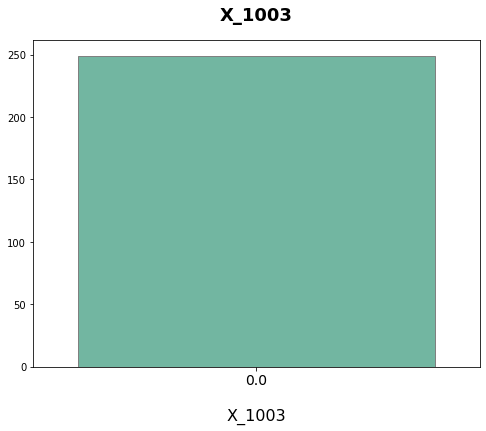

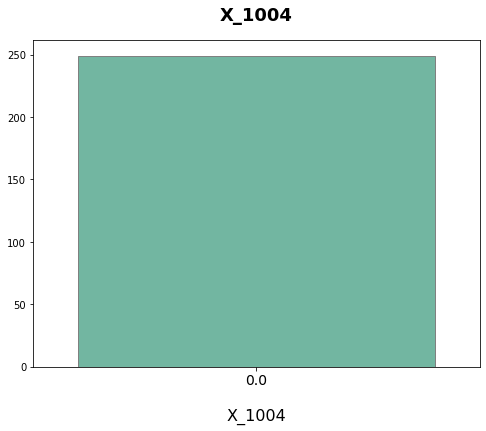

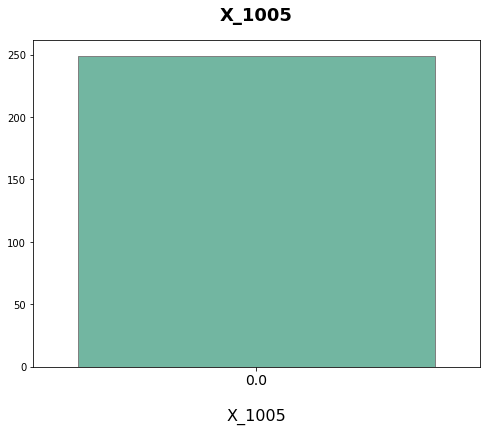

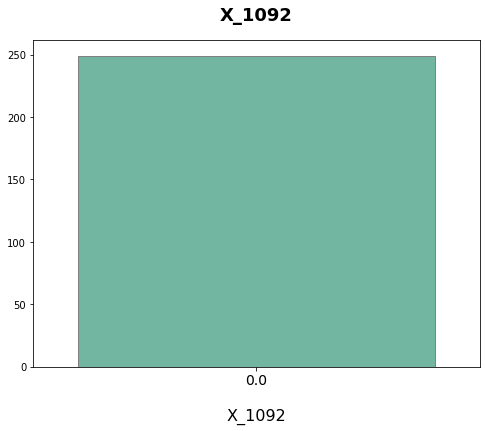

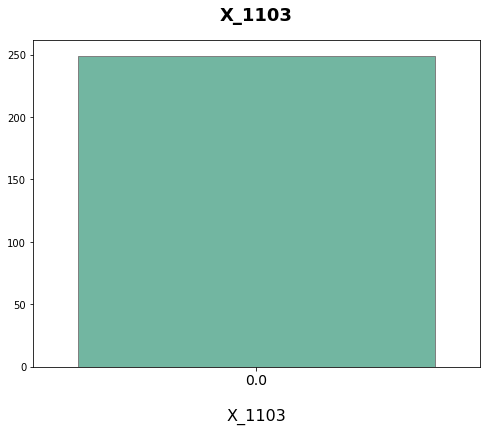

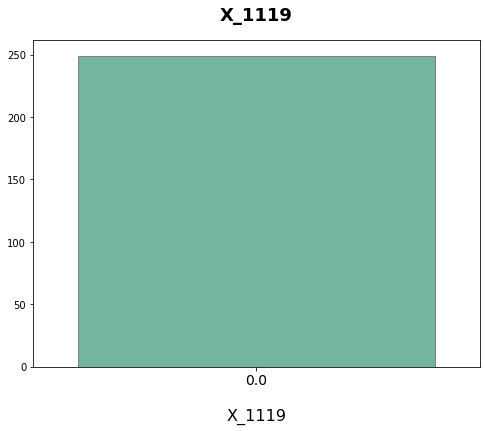

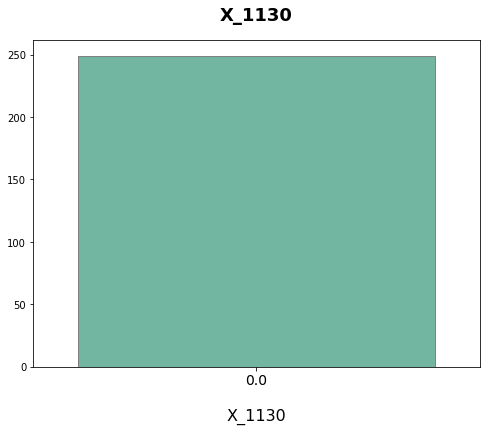

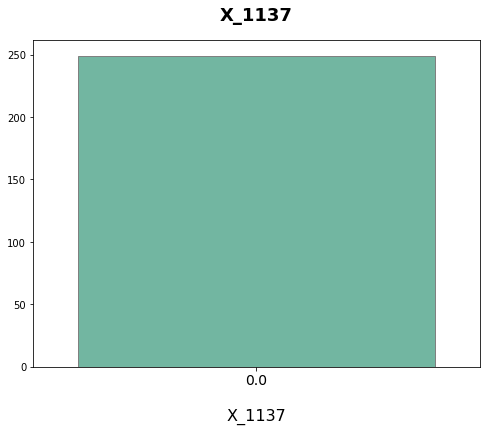

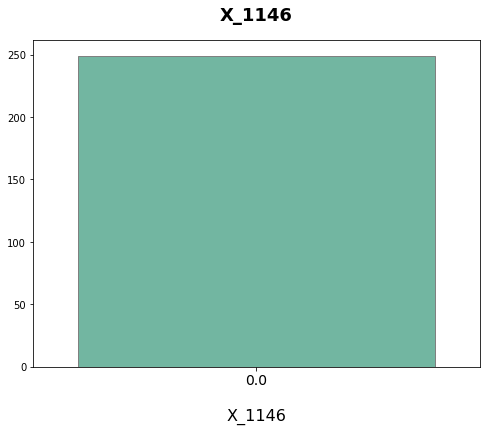

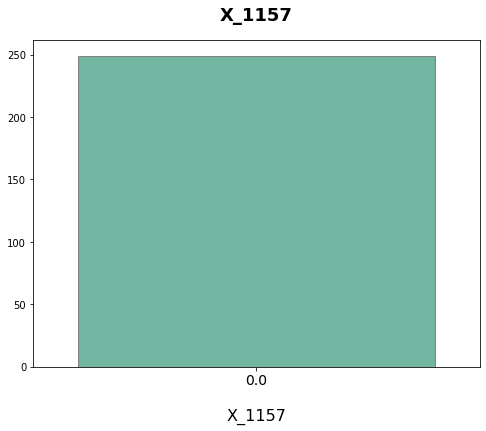

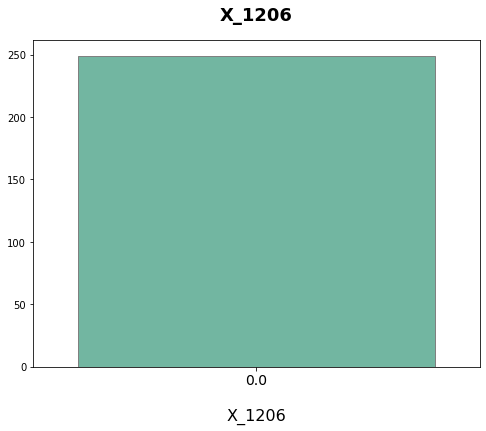

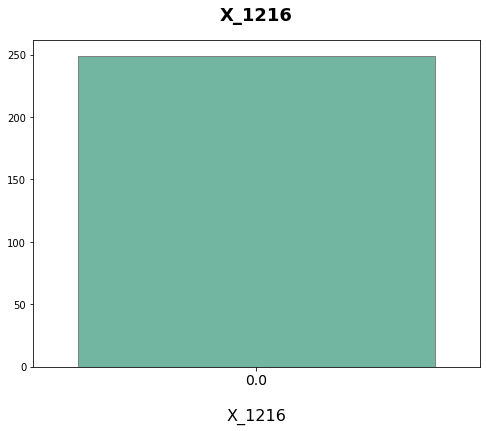

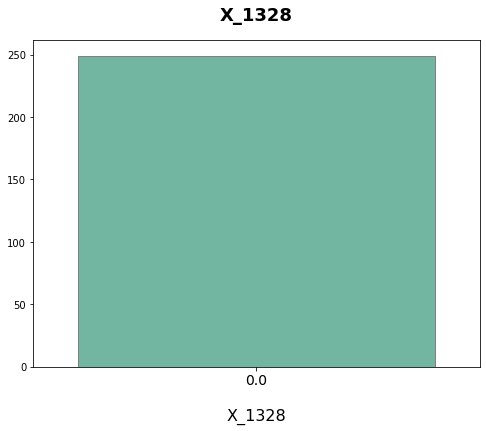

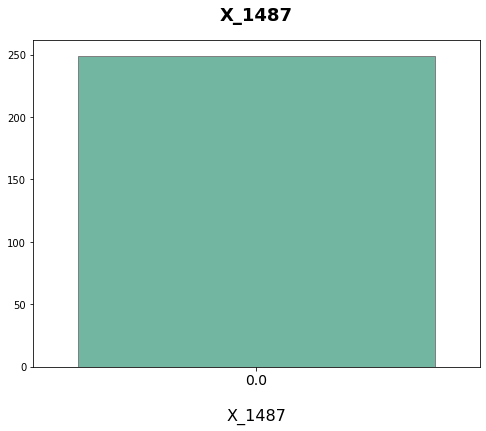

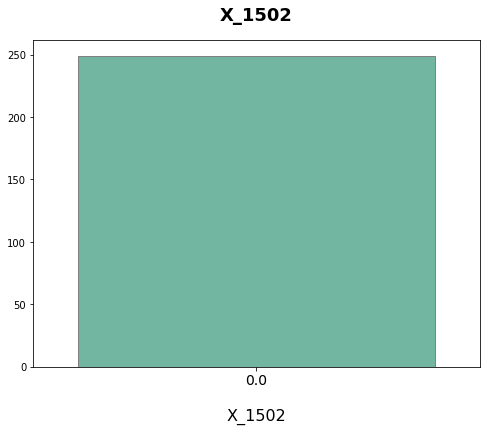

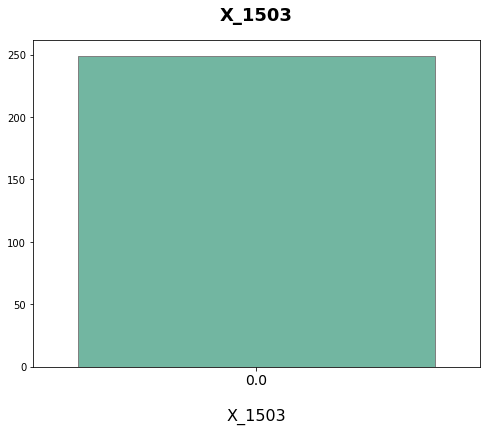

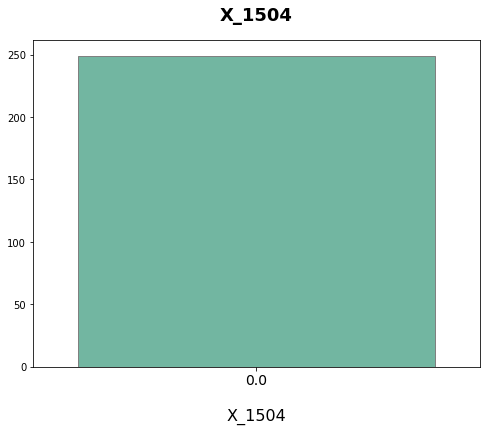

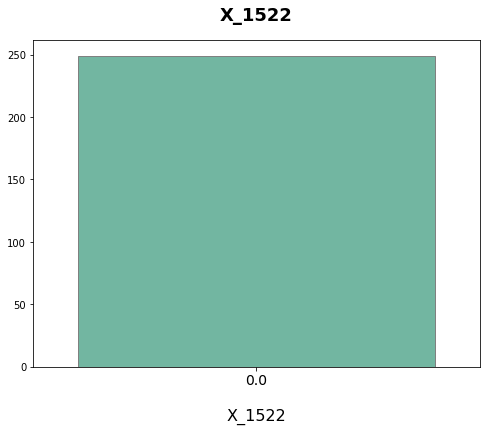

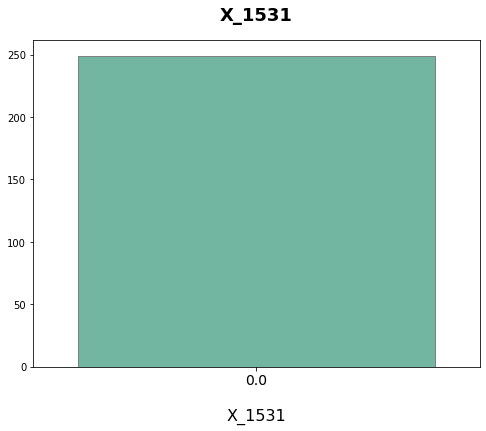

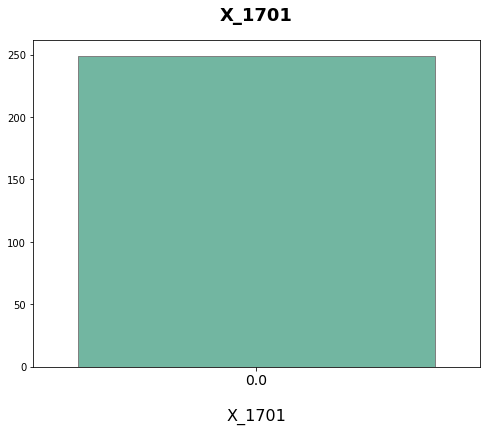

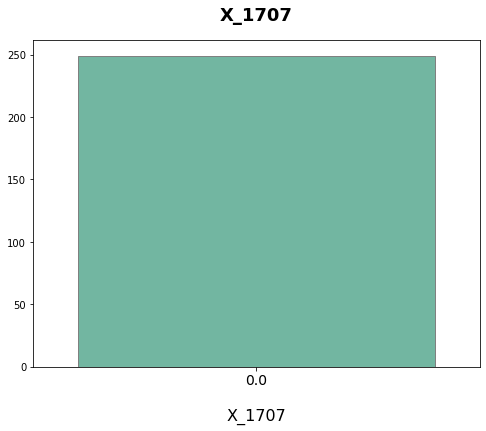

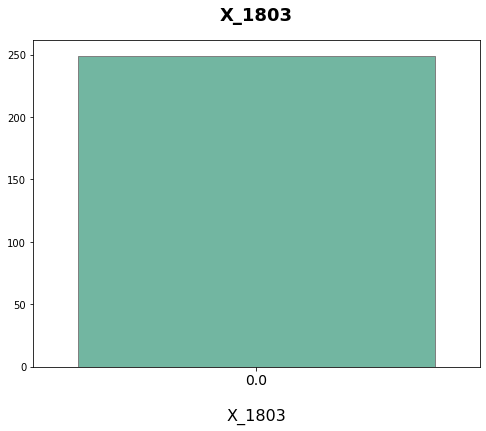

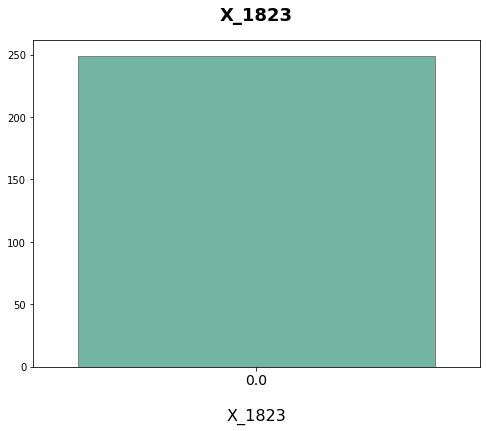

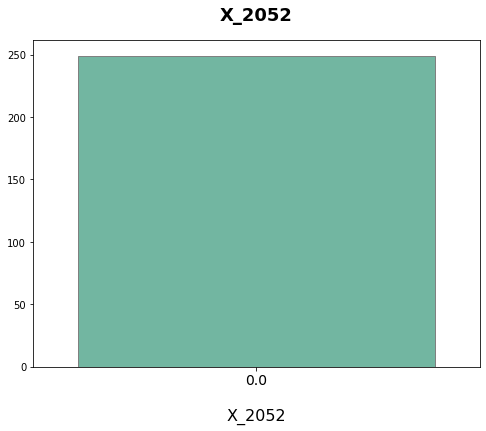

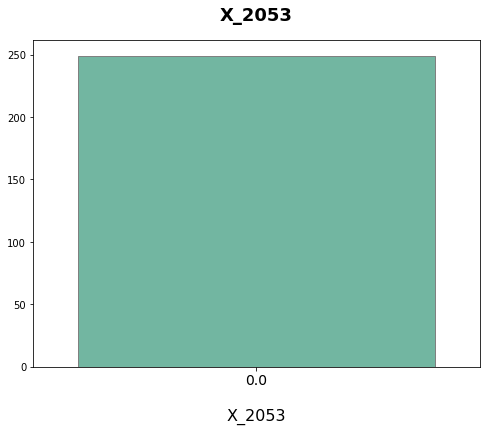

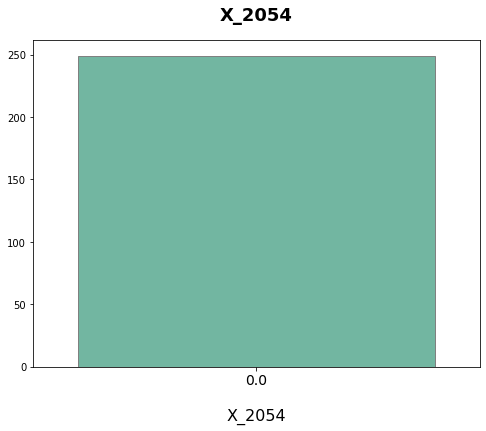

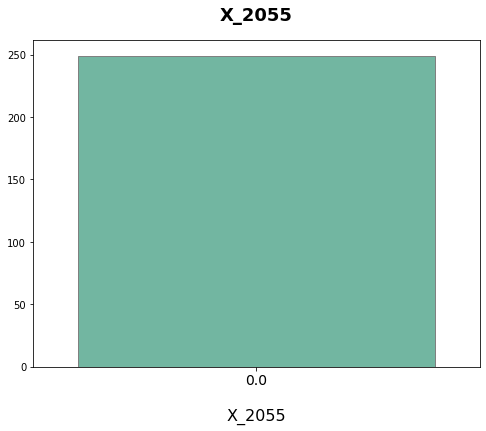

In [ ]:
# 다중공선성 제거 변수 분포
for i in no_vif.columns:
  sns.set_palette("Set2")

  fig, ax = plt.subplots(figsize=(8, 6))
  graph = sns.countplot(x=no_vif[i], edgecolor="grey")

  plt.xlabel(ax.get_xlabel(), fontsize=16, labelpad=20)
  plt.ylabel("", fontsize=16, labelpad=20)

  plt.xticks(fontsize=14)

  plt.title(str(i), fontsize=18, fontweight="bold", pad=20)

  plt.show()

In [ ]:
trainA_31_x=trainA_31_x.fillna(-1)
testA_31_x=testA_31_x.fillna(-1)
train_T_O_x=train_T_O_x.fillna(-1)
test_T_O_x=test_T_O_x.fillna(-1)

## ISSUE

1. NaN 너무 많음 -> 단순히 결측치 처리 fillna(0)은 아닌듯
2. column 수 너무 많음 -> 다중공선성 확인하고 변수개수 줄일 수 있으면 best. 이거 오늘할꺼
3. PRODUCT CODE 별 ? Y_CLASS 별? 알아봐야할듯

## Insight

1. Y_Class 별로 살펴보면 Y_Quality 는 유의미한 변수가 될 것 같다. (베이스라인 코드에서는 drop 되어있음)
  - <s>실제로 Y_Quality 넣고 valid set 결과 Decision Tree 모델 f1_score 0. 69 -> 0.99로 상승.
  - test set에 Y_Qulity column이 없어서 만들어 내야할듯. </s>
  - semi-supervised learning 해봤는데 성능이 그닥임. 근데 아이디어는 괜찮은듯

2. Y_Class 와 Y_Quality는 기능상 정답(label)을 의미하는 건 똑같은듯.
  - Y_Class를 이용한 분류와
  - Y_Quality를 이용한 회귀를 비교하여 앙상블 하는 것도 괜찮을 것 같음

## brief conclusion

1. baseline(RandomForest) : f1 score(valid set) 0.73수준
  - train_x를 train_x와 valid_x로 split
  - 교차검증 안함
  - f1_score(average='micro')

2. DecisionTree : f1 score(valid set) 0.69 수준
  - train_x를 train_x와 valid_x로 split
  - 교차검증 안함
  - f1_score(average='micro')
  - 시각화 진행 -> root node 분기 기준 = X_1856

3. LinearRegression : f1 score(valid set) 0.35수준
  - Linear로 나온 결과값에 범위에 따라 Class로 변환
  - train, test set을 인덱스 슬라이싱으로 구분 (Y_Quality로 회귀를 수행하고 class로 변환한 train set이 Y_Class와 정답을 비교하기 위해서)

4. 다희님 전처리 -> product_code 별 데이터 전처리
  - <s>수치형 데이터 -> cat 보다는 lgbm이 나을수도?</s> 0.56수준 별로임. 정규화를 안해줘서 그런가..?

5. 다중공선성(VIF 지수 이용)
  - 전체에 대해서 수행하는건 30분째 안돌아감.
  - line 별 혹은 product code별로 데이터를 쪼개서 살펴보는게 나을듯?

6. 민규님 duplicated 사용
  - linear regression 으로 y quality 예측 -> y_class 변환
  - 기존 모든 변수 포함 -> 0.4 (2199 columns. train A 31 기준)
  - duplicated 제거 -> 0.4 (1232 columns)
  - duplicated 제거 & 후진소거법 -> 0.4 (1189 columns)

7. 공장(LINE) 별로 생산하는 물품이 달랐다. O는 6개밖에 안되니까 가볍게 무시.
  - product code별로 묶는게 아니라 LINE별로 묶어야할듯
  - 이러면 label 변수도 자연스럽게 사라지고 product code는 고정되니까 무시가능할듯